# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math

In [2]:
df = pd.read_csv('reviews_full_v7.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.Graph()
B = nx.Graph()

In [5]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
        else:
            B.add_edge(user, genre, weight = 1)

In [6]:
B.number_of_nodes(), B.number_of_edges()

(8344, 33217)

[131, 125, 84, 82, 82, 81, 77, 75, 72, 72, 70, 67, 66, 64, 63, 62, 62, 61, 61, 60, 58, 55, 55, 54, 54, 54, 53, 53, 51, 51]


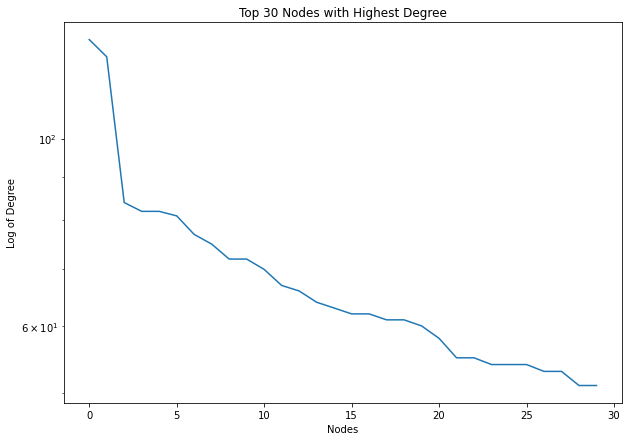

In [7]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
tmp = sorted([B.degree[user] for user in users])[-30:]
tmp.reverse()
plt.semilogy(tmp)
print(tmp)
plt.show()

In [8]:
#removing structural holes
remove_users = set()
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        remove_users.add(user)
        users.remove(user)

autothrall
hells_unicorn


In [9]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        for genre2 in B.adj[user]:
            if genre2 >= genre1:
                continue
            if G.has_edge(genre1,genre2):
                G[genre1][genre2]['weight'] += 1
            else:
                G.add_edge(genre1, genre2, weight = 1)

In [10]:
G.number_of_nodes(), G.number_of_edges()

(289, 18130)

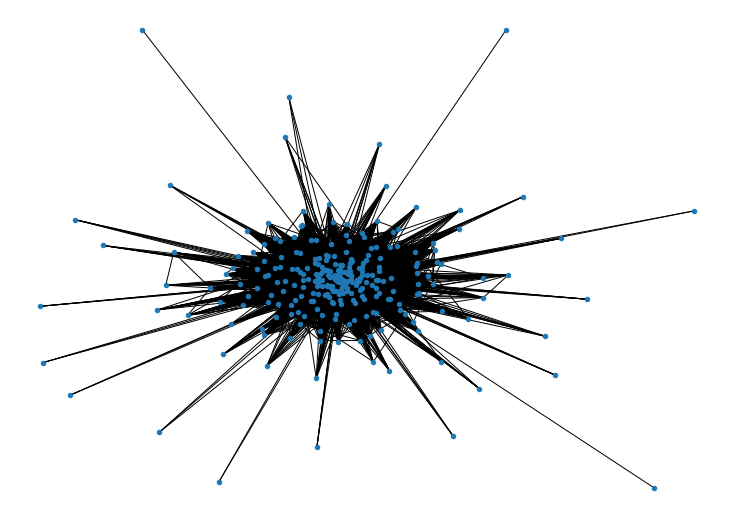

In [11]:
nx.draw(G, node_size = 20)

In [12]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [13]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

In [14]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

In [15]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group:
        pass
    elif  genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)
print(G.number_of_nodes())

289
190


In [16]:
G3 = G.copy()

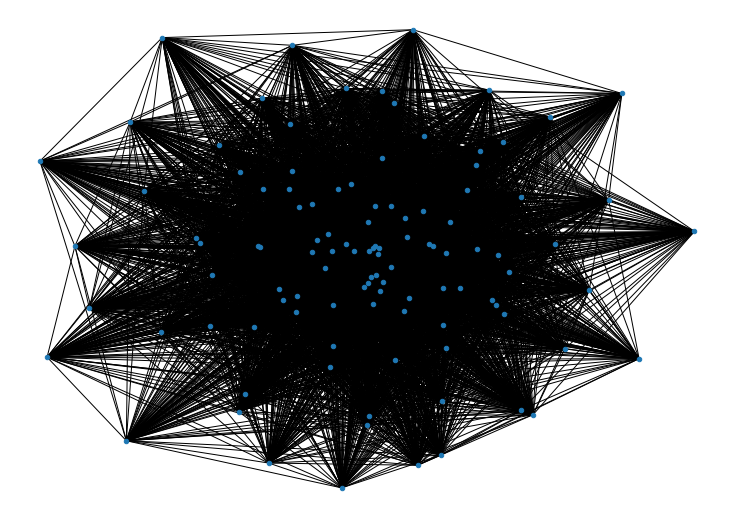

In [17]:
K = G3.copy()
K.remove_edges_from(nx.selfloop_edges(K))
K = nx.k_core(K)
sortbylen = lambda cc : len(cc)
Core = K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1])
nx.draw(Core, node_size = 20)

In [18]:
Core.number_of_nodes(),Core.number_of_edges()

(109, 5649)

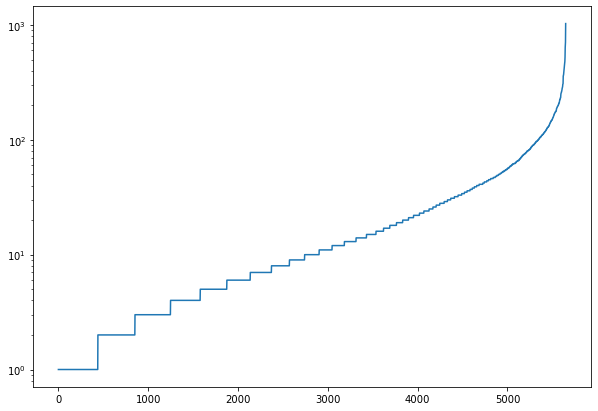

In [19]:
plt.semilogy(sorted(list(nx.get_edge_attributes(Core,'weight').values())))

In [20]:
tmp = sorted(list(nx.get_edge_attributes(Core,'weight').values()))
for i in range(len(tmp)):
    if (tmp[i] == 33):
        print(i)
        break

4450


(array([2136.,  911.,  643.,  330.,  275.,  195.,  167.,  132.,  128.,
          83.]),
 array([ 1. ,  6.5, 12. , 17.5, 23. , 28.5, 34. , 39.5, 45. , 50.5, 56. ]),
 <a list of 10 Patch objects>)

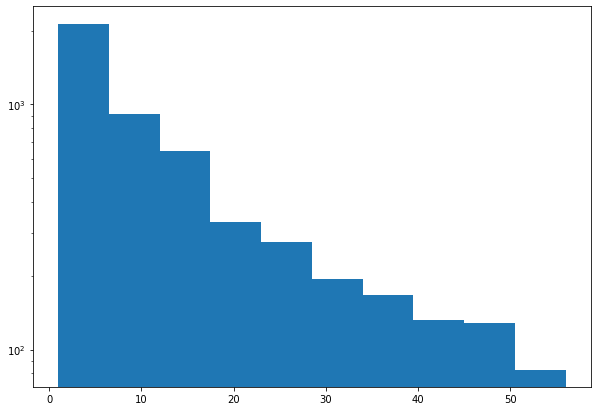

In [21]:
plt.hist(sorted(list(nx.get_edge_attributes(Core,'weight').values()))[:5000], log = True)

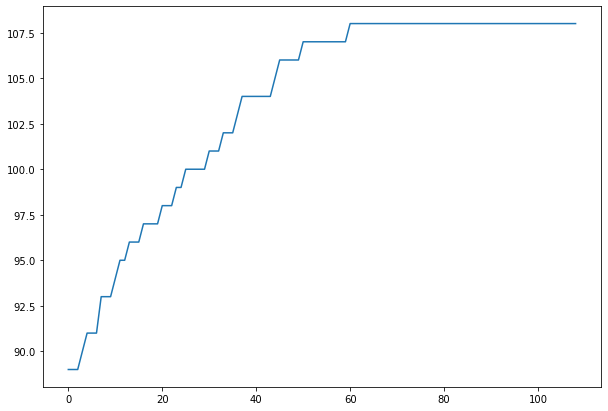

In [22]:
tmp = sorted([(v,u) for u,v in Core.degree])
#plt.xticks(rotation='vertical')
#plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
plt.plot([x[0] for x in tmp])
plt.show()

In [23]:
#on hold first
'''G = G3.copy()
G2 = G.copy()
print(list(nx.isolates(G)))

for u,v in G2.edges():
    if G2[u][v]['weight'] < 5: #10 for double counting
        G.remove_edge(u,v)
        
nx.number_connected_components(G)
print(clt.Counter([len(cc) for cc in nx.connected_components(G)]))
print(list(nx.isolates(G)))
G.remove_nodes_from(list(nx.isolates(G)))
G.number_of_nodes()'''

"G = G3.copy()\nG2 = G.copy()\nprint(list(nx.isolates(G)))\n\nfor u,v in G2.edges():\n    if G2[u][v]['weight'] < 5: #10 for double counting\n        G.remove_edge(u,v)\n        \nnx.number_connected_components(G)\nprint(clt.Counter([len(cc) for cc in nx.connected_components(G)]))\nprint(list(nx.isolates(G)))\nG.remove_nodes_from(list(nx.isolates(G)))\nG.number_of_nodes()"

In [24]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [25]:
'''tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]
mp = {}
for genre in tmp:
    for item in genre[1:]:
        mp[item] = genre[0]
pickle.dump(mp,open('genre_group.p','wb'))
f = open('genres.txt').read().split('\n')[:-1]
for item in f:
    if item not in genre_group:
        print(item)'''

"tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]\nmp = {}\nfor genre in tmp:\n    for item in genre[1:]:\n        mp[item] = genre[0]\npickle.dump(mp,open('genre_group.p','wb'))\nf = open('genres.txt').read().split('\n')[:-1]\nfor item in f:\n    if item not in genre_group:\n        print(item)"

In [26]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'weight', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [27]:
def plotThreshold(Graph, thres):
    J = Graph.copy()
    for u,v in Graph.edges():
        if Graph[u][v]['weight'] < thres: #10 for double counting
            J.remove_edge(u,v)
    J.remove_nodes_from(list(nx.isolates(J)))
    L = J.copy()
    while not no_crossedges(L):
        L = freq_network_parr(L, 10, 4)
    print(thres,nx.number_connected_components(J),nx.number_connected_components(L),J.number_of_nodes())
    comps = nx.connected_components(L)
    part = {}
    for i,comp in enumerate(comps):
        for x in comp:
            part[x] = i
    #return modularity(part,J)
    inter = 0
    intra = 0
    for u,v in J.edges():
        if part[u] == part[v]:
            intra += 1
        else:
            inter += 1
            
    return inter/intra

'''plt.title('Modularity against Weight Threshold')
plt.ylabel('Modularity')
mods = [plotThreshold(Core.copy(), i) for i in range(15,25)]
plt.plot(mods)
plt.show()'''

"plt.title('Modularity against Weight Threshold')\nplt.ylabel('Modularity')\nmods = [plotThreshold(Core.copy(), i) for i in range(15,25)]\nplt.plot(mods)\nplt.show()"

In [28]:
#print(list(enumerate(mods)))

In [29]:
#Use modularity and Inter-Intra edges to determine weight threshold
#Use value of 20 (remove any edge below 20)
CoreNew = nx.Graph(Core)
edgeThres = 20
for u,v in Core.edges():
    if Core[u][v]['weight'] < edgeThres:
        CoreNew.remove_edge(u,v)
print(list(nx.isolates(CoreNew)))
CoreNew.remove_nodes_from(list(nx.isolates(CoreNew)))
CoreNew.number_of_nodes(),CoreNew.number_of_edges()

['gothic black metal', 'electro industrial metal', 'instrumental post-metal', 'ambient doom metal', 'industrial thrash metal', 'extreme industrial metal', 'djent', 'extreme avantgarde metal', 'progressive sludge metal', 'progressive math metal', 'progressive folk metal', 'oriental folk metal']


(97, 1816)

In [30]:
CoreNew = Core

In [31]:
'''tmp = sorted([(v,u) for u,v in G3.degree])[-30:]
plt.xticks(rotation='vertical')
plt.plot([x[1] for x in tmp],[x[0] for x in tmp])
plt.ylabel('Degree')
plt.title('Degree of Top 30 Genres in Network of Genres')
plt.show()
remove_genres = [u for v,u in tmp[-16:] if len(u.split(' ')) <= 2]
print(remove_genres)
#G.remove_nodes_from(remove_genres)'''

"tmp = sorted([(v,u) for u,v in G3.degree])[-30:]\nplt.xticks(rotation='vertical')\nplt.plot([x[1] for x in tmp],[x[0] for x in tmp])\nplt.ylabel('Degree')\nplt.title('Degree of Top 30 Genres in Network of Genres')\nplt.show()\nremove_genres = [u for v,u in tmp[-16:] if len(u.split(' ')) <= 2]\nprint(remove_genres)\n#G.remove_nodes_from(remove_genres)"

In [32]:
#H = G.copy()
H = CoreNew.copy()
#0.9 is good
#H = freq_network_parr(H, 100, 4, res = 0.8)
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

1 5886 5649
1 5886 4021
1 5886 4021
3 2372 2372


In [33]:
partitions = [cc for cc in nx.connected_components(H)]

In [34]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [CoreNew.subgraph(comp) for comp in comps]
    ave_weight = [sum([CoreNew[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([CoreNew[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    std_dev = [np.std([CoreNew[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    #ave_coeff = [nx.average_clustering(CoreNew, nodes = sub.nodes(), weight = 'weight') for sub in subgraphs]
    ave_coeff = [nx.average_clustering(sub, weight = 'weight') for sub in subgraphs]
    #ave_weight1 = [np.mean([G[u][v]['weight'] for u,v in sub.edges()]) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density, std_dev, ave_coeff

In [35]:
[len(cc) for cc in partitions]

[47, 50, 12]

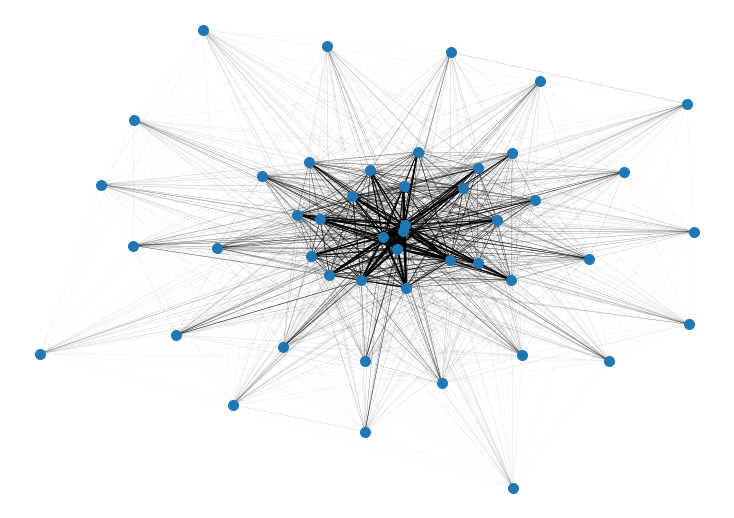

In [36]:
cluster = CoreNew.subgraph(list(nx.connected_components(H))[0])
nx.draw(cluster, node_size = 100,  font_size = 12, edge_color = 'black', width = np.array([CoreNew[u][v]['weight'] for u,v in cluster.edges()])*0.01)
plt.show()

In [37]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'], ret['Std_Dev'], ret['Average_Clustering_Coefficient'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
data = genData(H,1)
data

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{progressive metalcore, oriental folk metal, m...",47,22.954633,21.999075,0.958372,51.204741,0.021539
1,"{extreme avantgarde metal, drone doom metal, a...",50,22.050707,21.654694,0.982041,29.144492,0.066756
2,"{technical deathcore, progressive death metal,...",12,124.348485,124.348485,1.000000,166.040839,0.089823


In [38]:
clusters = []
inp = int(input('Enter Cluster ID to Keep: '))
clusters.append(G.subgraph(list(nx.connected_components(H))[inp]))

Enter Cluster ID to Keep:  2


In [39]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = CoreNew.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 4)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))
        for comp in nx.connected_components(G1):
            clusters.append(CoreNew.subgraph(comp))

In [40]:
inp = 0
tmp = []
inp = input('Enter Cluster IDs for Breakdown: ')
breakDown([int(x) for x in inp.split()])

Enter Cluster IDs for Breakdown:  0 1


1 1081 1036
1 1081 699
1 1081 699
2 531 454
2 531 454
2 531 531
End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{oriental folk metal, melodic thrash metal, in...",25,10.024735,9.456667,0.943333,12.291344,0.114847
1,"{progressive metalcore, melodic metalcore, dje...",22,48.748899,47.904762,0.982684,94.509694,0.045995


1 1225 1203
1 1225 709
1 1225 709
4 398 398
End Clustering:  1


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density,Std_Dev,Average_Clustering_Coefficient
0,"{extreme avantgarde metal, instrumental post-m...",25,19.789831,19.460000,0.983333,23.567499,0.105773
1,"{neofolk, post-metal, atmospheric black metal,...",8,38.714286,38.714286,1.000000,30.775520,0.234558
2,"{psychedelic stoner metal, drone doom metal, p...",11,35.727273,35.727273,1.000000,55.010893,0.096545
3,"{atmospheric doom metal, melodic doom metal, a...",6,24.000000,24.000000,1.000000,30.086542,0.168902


124.34848484848484


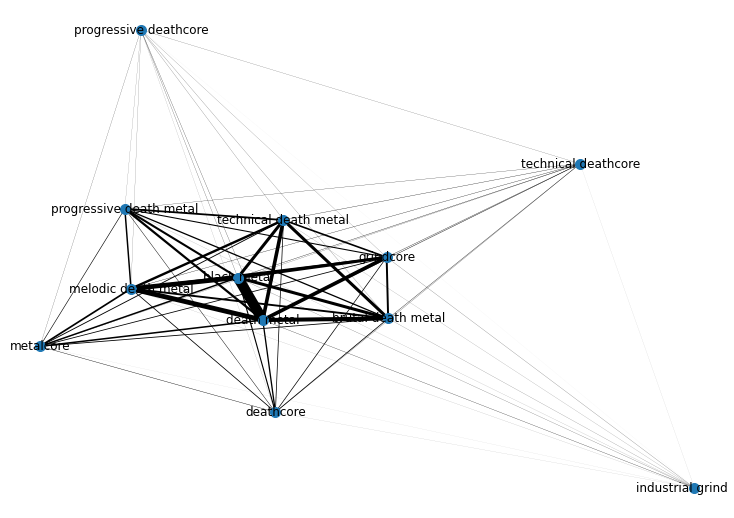

10.024734982332156


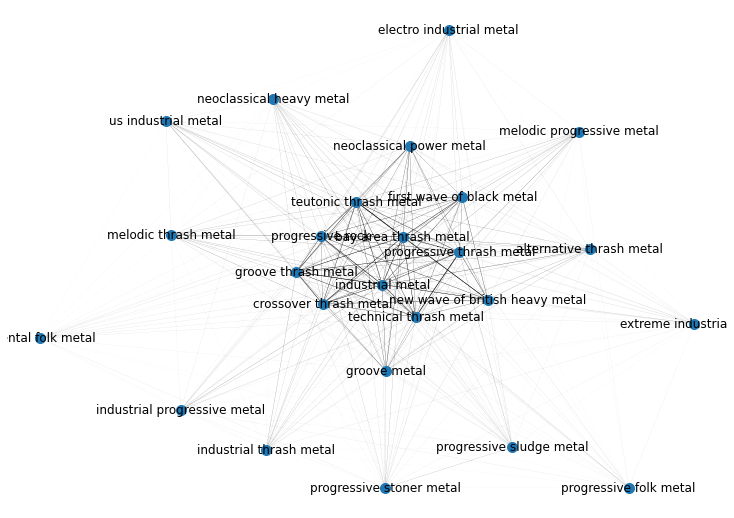

48.74889867841409


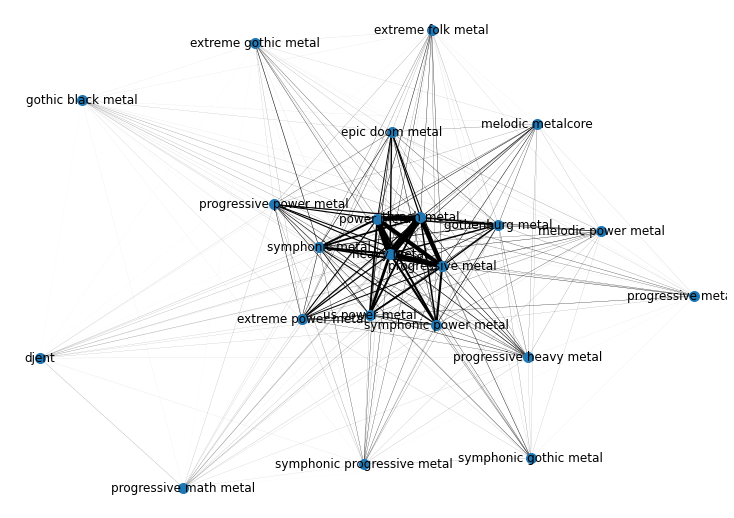

19.789830508474576


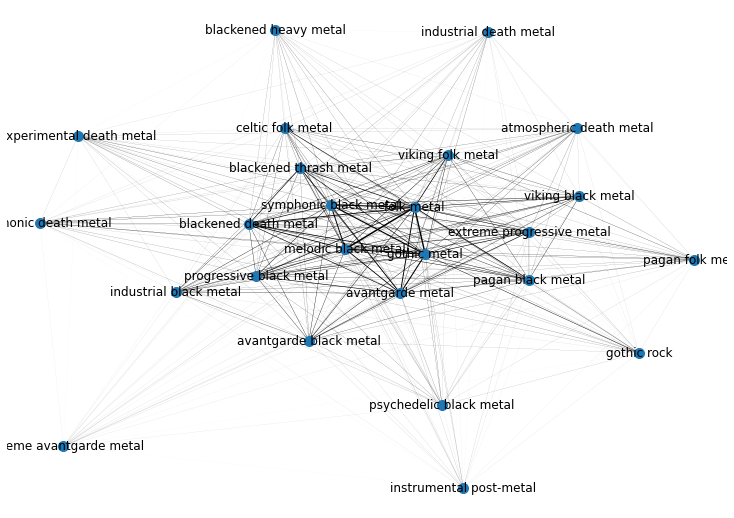

38.714285714285715


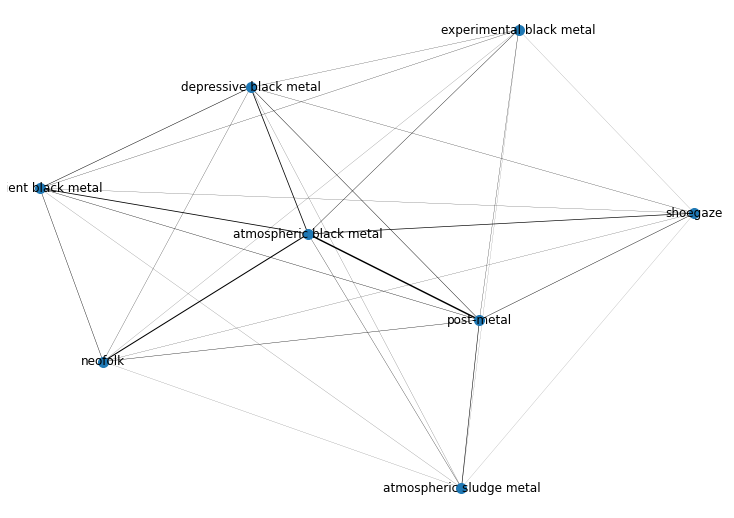

35.72727272727273


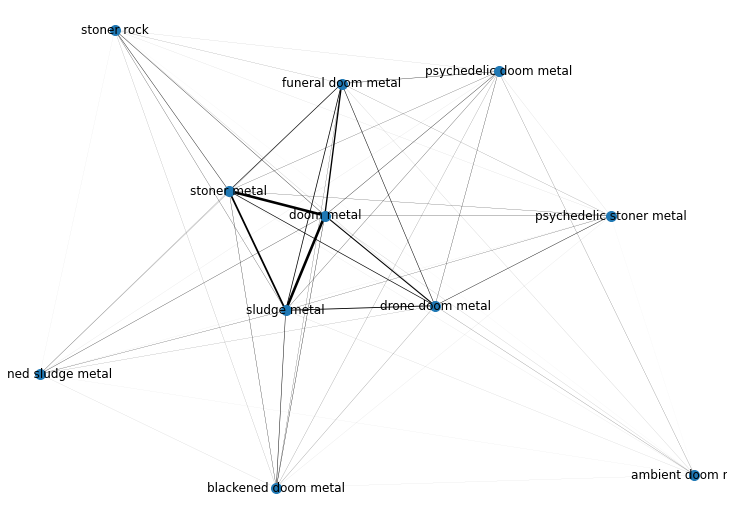

24.0


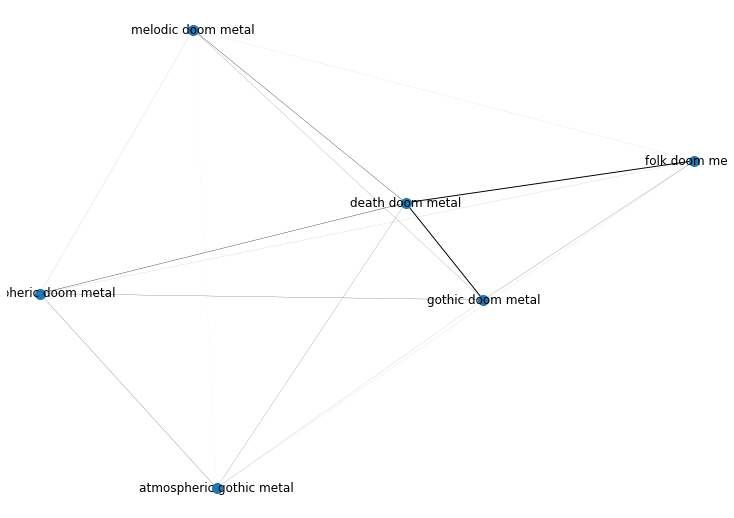

In [41]:
for cluster in clusters:
    nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])*0.01)
    print(np.mean(np.array([cluster[u][v]['weight'] for u,v in cluster.edges()])))
    plt.show()

In [ ]:
inp = input('Continue?')

In [ ]:
'''x = 'folk doom metal'
w = sorted([(CoreNew[x][u]['weight'],u) for u in list(CoreNew[x])])
w'''

In [ ]:
'''cluster = clusters[3]
nx.draw(cluster, node_size = 100, with_labels = True, font_size = 12, edge_color = 'black', width = np.array([CoreNew[u][v]['weight'] for u,v in cluster.edges()])*0.01)
plt.show()'''

In [ ]:
user_mp = clt.Counter(df['User'])
album_mp = clt.Counter(df['Release'])
#print(user_mp)
#print(album_mp)
plt.title('Frequency against Users/Albums')
plt.ylabel('Log of Frequency')
plt.xlabel('Users/Albums')
plt.loglog(sorted(user_mp.values()), label = 'Frequency of Users')
plt.loglog(sorted(album_mp.values()), label = 'Frequency of Albums')
plt.legend()
plt.show()

In [ ]:
parts = {}
for i,cluster in enumerate(clusters):
    for node in cluster.nodes():
        parts[node] = i

#finding users and genres in clusters

user_groups = [set() for i in range(len(clusters))]
album_groups = [set() for i in range(len(clusters))]

contexts = [set() for i in range(len(clusters))]

posScore = 75

user_mp = clt.Counter(df['User'])
album_mp = clt.Counter(df['Release'])

def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    album = row['Release'] + 'A'
    if user_mp[user] == 1 or album_mp[album] == 1 or user in remove_users:
        continue
    for genre in genre_list:
        if genre not in parts:
            continue
        user_groups[parts[genre]].add(user)
        album_groups[parts[genre]].add(album)
        contexts[parts[genre]].add((user,album))
            
print([len(user_groups[i]) for i in range(len(user_groups))])
print([len(album_groups[i]) for i in range(len(album_groups))])
print([len(contexts[i]) for i in range(len(contexts))])

In [ ]:
from concepts import Context

In [ ]:
def getConcepts(ind):
    context = contexts[ind]
    context_df = pd.DataFrame()
    user_list = list(user_groups[ind])
    album_list = list(album_groups[ind])
    for user in user_list:
        arr = []
        for album in album_list:
            if (user,album) in context:
                arr.append('X')
            else:
                arr.append('')
        context_df[user] = arr
    context_df.index = album_list 
    #display(context_df)
    context_df.to_csv('fca.csv')
    c = Context.fromfile('fca.csv', frmat = 'csv')
    l = c.lattice
    return l

In [ ]:
lats = []
for i in range(len(contexts)):
    print(i)
    lat = getConcepts(i)
    tmp = []
    for x,y in lat:
        tmp.append((x,y))
    lats.append(tmp)
pickle.dump(lats,open('lattices.p','wb'))

In [ ]:
lat = getConcepts(5)
len(lat)

In [ ]:
x, y = lat[650]
print(x,y)